In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import NearestNeighbors
import sys
from io import StringIO
import time

# Loading Data
I specified the data types of the attributes in the training set in order to allow it to be loaded completely into memory

In [2]:
dtypes = {
    'id': np.int32,
    'store_nbr': np.int16,
    'item_nbr': np.int32,
    'unit_sales': np.float32,
    'onpromotion': np.dtype("O")
}
start = time.clock()
train = pd.read_csv("data/~train.csv", dtype = dtypes, parse_dates=["date"])
test = pd.read_csv("data/~test.csv", dtype=dtypes, parse_dates=["date"])
stores = pd.read_csv("data/stores.csv", dtype = dtypes)
items = pd.read_csv("data/items.csv", dtype = dtypes)
transactions = pd.read_csv("data/transactions.csv", dtype = dtypes)
oil = pd.read_csv("data/oil.csv", dtype = dtypes, parse_dates=["date"])
holidays = pd.read_csv("data/holidays_events.csv", dtype = dtypes)
print("Took " + str(time.clock() - start) + " seconds to load")

Took 278.396186654435 seconds to load


# Preprocessing

## Interpolation
I used the pandas interpolate function to fill the NaN values in the daily oil price

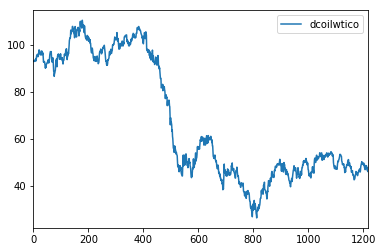

In [3]:
oil.dcoilwtico = oil.dcoilwtico.interpolate()
oil.date = pd.to_datetime(oil.date)
oil.plot(kind="line")

## Auxiliary Data
I converted the categorical data in the auxiliary datasets into one-hot encodings

In [4]:
holidays.type = holidays.type.astype("category")
holidays.locale = holidays.locale.astype("category")
holidays.locale_name = holidays.locale_name.astype("category")
holidays.description = holidays.description.astype("category")
holidays.transferred = holidays.transferred.astype(int)
holidays.date = pd.to_datetime(holidays.date)
one_hot_holidays = pd.get_dummies(holidays).groupby("date").sum().reset_index()

stores.city = stores.city.astype("category")
stores.state = stores.state.astype("category")
stores.type = stores.type.astype("category")
stores.cluster = stores.cluster.astype("category")
one_hot_stores = pd.get_dummies(stores)

items.family = items.family.astype("category")
items["class"] = items["class"].astype("category")
items.perishable = items.perishable.astype(np.uint8)
one_hot_items = pd.get_dummies(items)

## Train & Test Data
The id column has no bearing on the data, so it is removed from both datasets. However, it is needed for the Kaggle submission with the test data, so it is stored for later use.

I converted the onpromotion column into a binary value defaulting to 0 when the value is NaN in order to save memory by not storing strings.

In order to reduce training time, I will only use the training data from 2016 and 2017. This is because the test is based on dates in 2017 immediately after the end of the training set, so long-term trends are probably not important.

In [5]:
train = train.drop('id', axis = 1)
train.onpromotion = (train.onpromotion == "True").astype(np.uint8)
train = train[train.date.dt.year >= 2016].reset_index(drop=True)

ids = test.id
test = test.drop('id', axis = 1)
test.onpromotion = (test.onpromotion == "True").astype(np.uint8)

### Building Pivot Table
I used a pivot table to reshape the data to make it easier to train a neural network on.

The data is split into 2016 and 2017 in order to allow these memory-intensive operations to be performed.

The pivot tables have rows with the date and the unit sales of every item and are indexed by the store number and the date.

The date and store number are added to the tables as new columns and the date is also expanded into year, month, day, and day of week columns. The holiday data and oil price data is then joined into the tables to increase the amount of information available to the neural network.

Then, the pivot tables are combined into a single data frame to be used for training the neural network. The store numbers are encoded as one-hot vectors to allow them to be used by the neural network.

In [6]:
def build_pivot(df):
    df = df.pivot_table(index=["store_nbr", "date"], columns="item_nbr", values="unit_sales", fill_value=0)
    df["date"] = df.index.get_level_values("date")
    df["store_nbr"] = df.index.get_level_values("store_nbr")
    df.loc[:,"year"] = df.date.dt.year
    df.loc[:,"month"] = df.date.dt.month
    df.loc[:,"day"] = df.date.dt.day
    df.loc[:,"day_of_week"] = df.date.dt.dayofweek
    df = df.merge(one_hot_holidays, left_on = "date", right_on="date", how='left')
    df = df.merge(oil, left_on = "date", right_on="date", how='left')
    df = df.fillna(0)
    df = df.reset_index(drop=True)
    return df

s = time.clock()
print("Splitting Data")
train16 = train[train.date.dt.year == 2016].reset_index(drop=True)
train17 = train[train.date.dt.year == 2017].reset_index(drop=True)
print("Data Split in", time.clock() - s, "seconds")

s = time.clock()
print("Building 2016 Pivot Table")
pivoted16 = build_pivot(train16)
print("Building 2017 Pivot Table")
pivoted17 = build_pivot(train17)
print("Pivot Tables Built in", time.clock() - s, "seconds")

s = time.clock()
print("Combining Pivot Tables")
data = pd.concat([pivoted16, pivoted17], ignore_index=True).fillna(0)
data.store_nbr = data.store_nbr.astype("category")
print("Encoding Store Numbers as One-Hot Vectors")
data = pd.get_dummies(data)
data

Splitting Data
Data Split in 12.630560915617366 seconds
Building 2016 Pivot Table
Building 2017 Pivot Table
Pivot Tables Built in 134.41171338227815 seconds
Combining Pivot Tables
Encoding Store Numbers as One-Hot Vectors


,99197,103501,103520,103665,105574,105575,105576,105577,105693,105737,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
0,0,0,1,0,2,10,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,2,6,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3,0,13,15,0,7,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,9,15,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,3,7,21,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,2,1,3,9,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,4,21,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,3,6,4,18,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,5,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,2,2,3,8,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


# Neural Network

## Defining Inputs & Outputs
The neural network's output is the vector of unit_sales values for each item number. 

Its input is every other data attribute.

In [8]:
input_cols = [col for col in data.columns.values if type(col) == str and col != "date"]
output_cols = [col for col in data.columns.values if type(col) == int]
print("Input size:", len(input_cols))
print("Output size:", len(output_cols))

Input size: 196
Output size: 4036


## Custom Sampling
The pandas built-in sampling function is slow, so I implemented a function that just uses the Numpy random number generator to perform the sampling more quickly.

In [9]:
def sample(df, n):
    indices = set()
    while len(indices) < n:
        indices.add(np.random.randint(0, len(df)))
    return df.loc[indices, :]

## Model Training
The neural network is defined using sklearn's MLPRegressor with an input size of 196, hidden layers of size 256 and 512, and an output size of 4036.

Many training runs are performed by repeatedly sampling the training data and then using the sklearn fit function to train the regressor.

In [12]:
model = MLPRegressor(
    hidden_layer_sizes=(256, 512),  # Hidden layer definition
    activation="relu",              # Use relu units to speed up training
    warm_start=True                # Don't overwrite previous fit
)

num_runs = 10
sample_size = 1000
s = time.clock()
for i in range(num_runs):
    S = time.clock()
    sampled_data = sample(data, sample_size)
    X = sampled_data[input_cols].as_matrix().astype(np.float32)
    Y = sampled_data[output_cols].as_matrix().astype(np.float32)
    
    model.fit(X, Y)
    print(i+1, "/", num_runs, "took", time.clock() - S, "seconds")
print("Model took", time.clock() - s, "seconds to train")

1 / 10 took 19.271321392183154 seconds
2 / 10 took 1.2264045930251086 seconds
3 / 10 took 15.861544860329104 seconds
4 / 10 took 1.2131550423014232 seconds
5 / 10 took 9.480225964878855 seconds
6 / 10 took 1.2528136434259523 seconds
7 / 10 took 1.2224312035607454 seconds
8 / 10 took 1.2587244856624693 seconds
9 / 10 took 1.3323696767108686 seconds
10 / 10 took 1.2709858842727044 seconds
Model took 53.44565027848057 seconds to train


# Kaggle Test Data Results

## Test Data Processing
A mapping is built from date, store number, and item number to the predicted unit sales values in order to prevent unnecessary calculations.

Since the training set did not include every item number that is in the test set, K Nearest Neighbors is used to find the most similar items to an unknown one and average their unit sales.

The results of running on the test data are output into a csv file named submission.csv.

In [15]:
def build_input(date, store_nbr):
    result = pd.DataFrame({
        "date": [date],
        "store_nbr": [store_nbr]
    })
    result.date = pd.to_datetime(date)
    result.loc[:,"year"] = result.date.dt.year
    result.loc[:,"month"] = result.date.dt.month
    result.loc[:,"day"] = result.date.dt.day
    result.loc[:,"day_of_week"] = result.date.dt.dayofweek
    result.store_nbr = result.store_nbr.astype("category", categories = np.arange(1, 55))
    result = pd.get_dummies(result)
    result = result.merge(one_hot_holidays, left_on = "date", right_on="date", how='left')
    result = result.merge(oil, left_on = "date", right_on="date", how='left')
    result = result.fillna(0)
    result = result[input_cols]
    return result

# Mapping from item number to index in neural net output vector
item_nbr_to_index = {nbr: i for i, nbr in enumerate(output_cols)}

# The items that have been found
known_items = one_hot_items[one_hot_items.item_nbr.map(lambda x: x in output_cols)]

num_neighbors = 3
neighbors = NearestNeighbors(num_neighbors)
neighbors.fit(known_items.drop("item_nbr", axis=1))
test_data = test.copy()
test_data["id"] = ids
results = {}
output = []
s = time.clock()
S = s
with open("data/submission.csv", "w") as file:
    file.write("id,unit_sales\n")
    for i in range(len(test_data)):
        date = test_data.loc[i, "date"]
        store_nbr = test_data.loc[i, "store_nbr"]
        item_nbr = test_data.loc[i, "item_nbr"]
        line_id = ids[i]
        if date not in results:
                results[date] = {}
        if store_nbr not in results[date]:
            results[date][store_nbr] = model.predict(build_input(date, store_nbr))[0]

        if item_nbr not in item_nbr_to_index:
            current_item = one_hot_items[one_hot_items.item_nbr == item_nbr].drop("item_nbr", axis=1)
            neighbor_indices = neighbors.kneighbors(current_item)[1][0]
            unit_sales = np.sum(known_items.loc[neighbor_indices, "item_nbr"].values) / num_neighbors
        else:
            unit_sales = results[date][store_nbr][item_nbr_to_index[item_nbr]]
        unit_sales = max(0, unit_sales)
        file.write(str(line_id) + "," + str(unit_sales) + "\n")
        if i % 10000 == 0:
            sys.stdout.write("\r" + str(i) + " / " + str(len(test_data)) + " took " + str(time.clock() - S) + " seconds       ")
            sys.stdout.flush()
            S = time.clock()
    sys.stdout.write("\r" + str(len(test_data)) + " / " + str(len(test_data)) + " took " + str(time.clock() - S) + " seconds       ")
    sys.stdout.flush()
    print()
print("Took", time.clock() - s, "seconds to process test data")

3370464 / 3370464 took 0.22381058078735805 seconds       
Took 671.5755349077308 seconds to process test data


## Kaggle Results
With training overnight, this neural net gets a score of 1.062 based on the Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE) calculated as follows.

$$ NWRMSLE=\sqrt{\frac{\sum_{i=1}^n\left(w_i\left(\ln\left(y_i+1\right)-\ln\left(Y_i+1\right)\right)^2\right)}{\sum_{i=1}^nw_i}}$$

where for row i, $y_i$ is the predicted unit sales and $Y_i$ is the actual unit sales. $w_i$ is either 1 or 1.25 depending on whether the item in question is perishable or not